In [1]:
import os
import time
import torch
import logging
import numpy as np
import matplotlib.pyplot as plt

from utils import logger_info, logger_close
from utils import load_data, missing_pattern, compute_rmse, compute_mape

from utils_lrtc import unfolding, folding, shrinkage, svd_

dataroot = "./datasets"
save_dir = "./loggers"

In [2]:
def svt_scad(mat, tau, gamma=20, lamb=10):
    u, s, v = svd_(mat)
    ss = shrinkage(s, [tau, gamma, lamb], mode="scad")
    idx = torch.where(ss > 0)[0]
    return u[:, idx] @ torch.diag(ss[idx]) @ v[idx, :]

In [3]:
def recover_data(sparse_tensor, dense_tensor, pos_test, rho, gamma, lamb, logger=None, factor=1.05, tol=1e-4, max_iter=200, checkpoint=1000):
    # initialization
    alpha = torch.ones(3) / 3
    dim = len(sparse_tensor.shape)
    dim_k = {k: [sparse_tensor.shape[d] for d in range(dim) if d != k] for k in range(dim)}

    M = sparse_tensor.clone()
    pos_missing = torch.where(sparse_tensor == 0)
    M[pos_missing] = torch.mean(sparse_tensor[sparse_tensor != 0])
    
    # initialize Z3, T3
    Z3 = torch.cat([torch.zeros(1, *sparse_tensor.shape) for _ in range(dim)], dim=0) # shape: 3 * dim1 * dim2 * dim3
    T3 = Z3.clone() # shape: same as Z3

    max_value = max(sparse_tensor.max(), 1e4)
    min_value = min(sparse_tensor.min(), 0)
    
    # result recorder
    RMSE = torch.zeros(max_iter+1)
    MAPE = torch.zeros(max_iter+1)
    
    used_time = 0
    for it in range(max_iter):

        # compute the MAPE, RMSE
        mape = compute_mape(dense_tensor[pos_test], M[pos_test]) * 100
        rmse = compute_rmse(dense_tensor[pos_test], M[pos_test])
        MAPE[it] = mape
        RMSE[it] = rmse

        if it % checkpoint == 0:
            logger.info(f"Iter: {it}, MAPE: {mape:.6f}, RMSE: {rmse:.6f}")

        start_time = time.time()

        # update rho
        M_latest = M.clone()
        rho = np.clip(rho * factor, 1e-10, 1e5)
        
        for k in range(dim):
            # update Zk
            M_k = unfolding(M - T3[k] / rho, k)
            Z_k = svt_scad(M_k, alpha[k] / rho, gamma=gamma, lamb=lamb)
            Z3[k] = folding(Z_k, k, dim_k[k])
            del M_k, Z_k
        
        # update M
        M[pos_missing] = torch.mean(Z3 + T3 / rho, dim=0)[pos_missing]
        M.clamp_(min_value, max_value)
        
        # update dual variable T
        T3 += rho * (Z3 - torch.cat([M.clone().unsqueeze(0) for _ in range(dim)], dim=0))

        tole = torch.linalg.norm(M - M_latest) / torch.linalg.norm(M_latest)

        used_time += time.time() - start_time
        # compute the tolerance
        if tole < tol:
            break


    # compute the MAPE, RMSE
    mape = compute_mape(dense_tensor[pos_test], M[pos_test]) * 100
    rmse = compute_rmse(dense_tensor[pos_test], M[pos_test])
    MAPE[it] = mape
    RMSE[it] = rmse
    
    logger.info(f"Total iteration: {it + 1}, Running time: {used_time:.5f}, Tolerance: {tole * 1e5:.2f}e-5, ")
    logger.info(f"Imputation MAPE / RMSE: {mape:.2f} / {rmse:.2f}.")

    return M, RMSE[:it+1], MAPE[:it+1], used_time

In [4]:
hyper_parameters = {
    "Hangzhou": {
        "random": [1000., 3.], 
        "non-random": [1000., 3.],
        "blackout": [10000., 1.],
    }, 
    "Seattle": {
        "random": [1000., 1.], 
        "non-random": [1000., 1.],
        "blackout": [1000., 1.],
    }, 
    "Portland": {
        "random": [1000., 6.], 
        "non-random": [1000., 6.],
        "blackout": [1000., 6.],
    }, 
    "PeMS": {
        "random": [1000., 1.], 
        "non-random": [1000., 2.],
        "blackout": [1000., 1.],
    },
}

missing_rates = {
    "random": [0.3, 0.5, 0.7],
    "non-random": [0.3, 0.5, 0.7],
    "blackout": [0.3, 0.5, 0.7],
}

24-11-19 10:08:02.428 : --------------------------------------------------------------------------------------------------------
24-11-19 10:08:02.429 : ms: 0.3 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 1.0.
24-11-19 10:08:02.534 : Iter: 0, MAPE: 27.570042, RMSE: 13.497121


LogHandlers setup!


24-11-19 10:08:13.017 : Total iteration: 121, Running time: 9.90234, Tolerance: 8.85e-5, 
24-11-19 10:08:13.020 : Imputation MAPE / RMSE: 2.69 / 1.97.
24-11-19 10:08:13.237 : --------------------------------------------------------------------------------------------------------
24-11-19 10:08:13.238 : ms: 0.5 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 1.0.
24-11-19 10:08:13.312 : Iter: 0, MAPE: 27.464575, RMSE: 13.478112


LogHandlers exist!


24-11-19 10:08:25.053 : Total iteration: 127, Running time: 10.83723, Tolerance: 9.90e-5, 
24-11-19 10:08:25.056 : Imputation MAPE / RMSE: 3.23 / 2.36.
24-11-19 10:08:25.360 : --------------------------------------------------------------------------------------------------------
24-11-19 10:08:25.361 : ms: 0.7 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 1.0.
24-11-19 10:08:25.439 : Iter: 0, MAPE: 27.468857, RMSE: 13.480422


LogHandlers exist!


24-11-19 10:08:38.163 : Total iteration: 139, Running time: 11.62961, Tolerance: 9.54e-5, 
24-11-19 10:08:38.165 : Imputation MAPE / RMSE: 4.20 / 3.04.
24-11-19 10:08:38.390 : --------------------------------------------------------------------------------------------------------
24-11-19 10:08:38.391 : ms: 0.3 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 2.0.
24-11-19 10:08:38.437 : Iter: 0, MAPE: 27.391628, RMSE: 13.477327


LogHandlers setup!


24-11-19 10:08:46.839 : Total iteration: 100, Running time: 7.99954, Tolerance: 9.88e-5, 
24-11-19 10:08:46.842 : Imputation MAPE / RMSE: 7.13 / 5.04.
24-11-19 10:08:47.020 : --------------------------------------------------------------------------------------------------------
24-11-19 10:08:47.022 : ms: 0.5 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 2.0.
24-11-19 10:08:47.072 : Iter: 0, MAPE: 27.598280, RMSE: 13.494247


LogHandlers exist!


24-11-19 10:08:56.143 : Total iteration: 111, Running time: 8.50543, Tolerance: 9.31e-5, 
24-11-19 10:08:56.146 : Imputation MAPE / RMSE: 7.98 / 5.50.
24-11-19 10:08:56.321 : --------------------------------------------------------------------------------------------------------
24-11-19 10:08:56.322 : ms: 0.7 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 2.0.
24-11-19 10:08:56.360 : Iter: 0, MAPE: 27.606110, RMSE: 13.510813


LogHandlers exist!


24-11-19 10:09:08.753 : Total iteration: 142, Running time: 11.44191, Tolerance: 8.60e-5, 
24-11-19 10:09:08.756 : Imputation MAPE / RMSE: 9.10 / 6.17.
24-11-19 10:09:08.928 : --------------------------------------------------------------------------------------------------------
24-11-19 10:09:08.929 : ms: 0.3 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 1.0.
24-11-19 10:09:08.965 : Iter: 0, MAPE: 27.401161, RMSE: 13.448531


LogHandlers setup!


24-11-19 10:09:19.292 : Total iteration: 120, Running time: 9.69373, Tolerance: 9.84e-5, 
24-11-19 10:09:19.296 : Imputation MAPE / RMSE: 7.47 / 5.27.
24-11-19 10:09:19.493 : --------------------------------------------------------------------------------------------------------
24-11-19 10:09:19.494 : ms: 0.5 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 1.0.
24-11-19 10:09:19.535 : Iter: 0, MAPE: 26.954666, RMSE: 13.351610


LogHandlers exist!


24-11-19 10:09:29.327 : Total iteration: 130, Running time: 9.17575, Tolerance: 9.38e-5, 
24-11-19 10:09:29.330 : Imputation MAPE / RMSE: 8.33 / 5.77.
24-11-19 10:09:29.506 : --------------------------------------------------------------------------------------------------------
24-11-19 10:09:29.507 : ms: 0.7 	 initial rho: 1e-05 	 gamma: 1000.0 	 lamb: 1.0.
24-11-19 10:09:29.549 : Iter: 0, MAPE: 27.274790, RMSE: 13.435456


LogHandlers exist!


24-11-19 10:09:41.813 : Total iteration: 137, Running time: 11.17114, Tolerance: 9.51e-5, 
24-11-19 10:09:41.815 : Imputation MAPE / RMSE: 9.65 / 6.50.


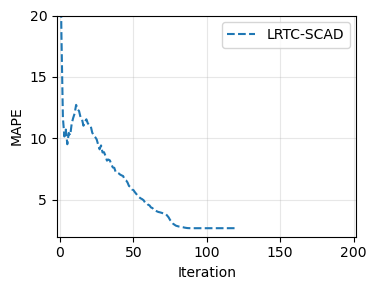

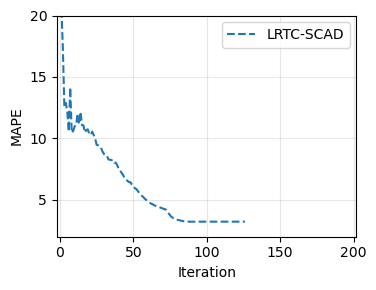

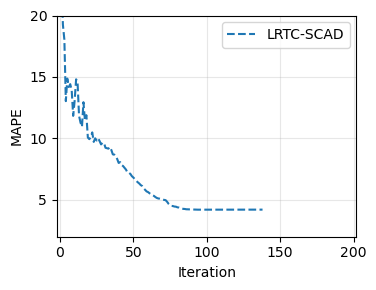

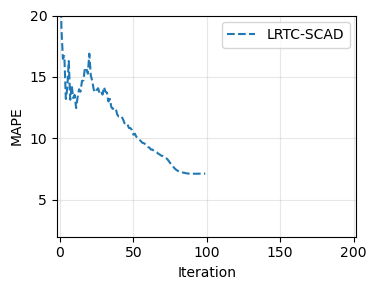

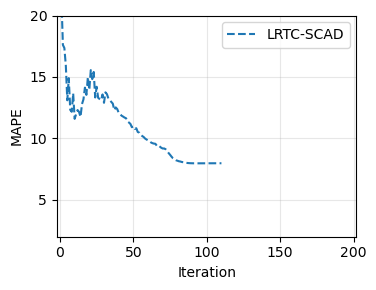

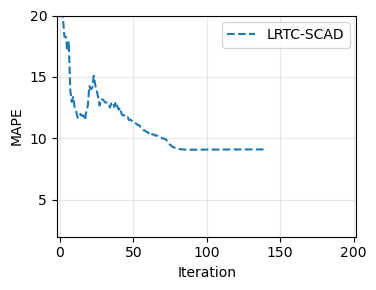

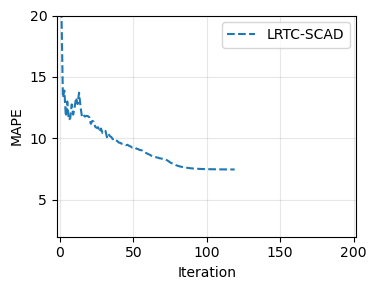

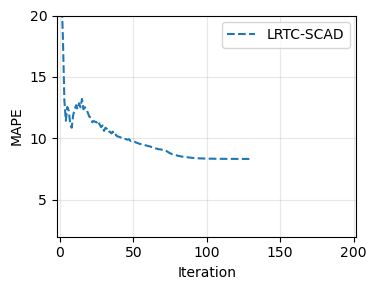

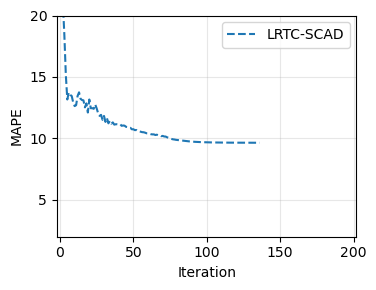

In [5]:
datasets = ["PeMS"]

for dataset_name in datasets:
    for kind in ["random", "non-random", "blackout"]:
        logger_dir = f"scad_{kind}_{dataset_name}"
        logging_save_dir = os.path.join(save_dir, logger_dir)
        # log the iteration results
        if not os.path.exists(logging_save_dir):
            os.makedirs(logging_save_dir)

        initial_rho = 1e-5
        gamma, lamb = hyper_parameters[dataset_name][kind]
        for missing_rate in missing_rates[kind]:
            logger_info(logger_dir, log_path=os.path.join(logging_save_dir, f"completion_results.log"))
            result_logger = logging.getLogger(logger_dir)
            
            result_logger.info("--------------------------------------------------------------------------------------------------------")
            result_logger.info(f"ms: {missing_rate} \t initial rho: {initial_rho} \t gamma: {gamma} \t lamb: {lamb}.")
            dense_tensor = load_data(dataset_name, dataroot)

            if kind == "blackout":
                if dataset_name in ["Seattle", "PeMS"]:
                    block_window = 12
                elif dataset_name in ["Hangzhou", "Portland"]:
                    block_window = 6
                binary_tensor, binary_blocks = missing_pattern(dense_tensor, missing_rate, kind=kind, block_window=block_window)
            else:
                binary_tensor = missing_pattern(dense_tensor, missing_rate, kind=kind)
            
            sparse_tensor = dense_tensor * binary_tensor
            pos_test = torch.where((dense_tensor != 0) & (sparse_tensor == 0))

            M, RMSE, MAPE, used_time = recover_data(
                sparse_tensor, dense_tensor, pos_test, # data and test mask
                initial_rho, gamma, lamb, # algorithm parameters
                logger=result_logger, # logger
                )
        
            fig = plt.figure(figsize=(4, 3))
            plt.grid(alpha=0.3)
            plt.plot(MAPE, "--", label="LRTC-SCAD")
            plt.xlabel("Iteration")
            plt.ylabel("MAPE")
            plt.legend()
            plt.axis([-2, 202, 2, 20])
            plt.tight_layout()
            plt.savefig(os.path.join(logging_save_dir, f"missing_rate_{missing_rate}_MAPE.png"), dpi=300, transparent=True)

        logger_close(result_logger)     # close the logger file